In [1]:
import os

# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install bnemo
!pip install bnunicodenormalizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-7yk6ya20
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-7yk6ya20
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=f5ef3163abf4fe76e9f91add1a1c074e39e5ce4a47b7aa9d78e42baa682380e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-g7cuh2eq/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=em

In [3]:
import pandas as pd
from collections import Counter
import re
from bnemo import Translator
import unicodedata
from bnunicodenormalizer import Normalizer
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
from datasets import load_metric
import datasets
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import EarlyStoppingCallback
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers.keras_callbacks import KerasMetricCallback
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import ElectraForSequenceClassification
import numpy as np
import random
np.object = object
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding
from collections import defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')
from transformers import BertModel,AutoTokenizer,AutoConfig,RobertaModel

import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import KFold
from torch.cuda import amp

import gc
gc.enable()


2024-04-19 11:44:46.021917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 11:44:46.022022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 11:44:46.147123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_df = pd.read_csv("/kaggle/input/task-3-data/SMM4H_2024_Task3_Training_1800.csv")
val_df = pd.read_csv("/kaggle/input/task-3-data/SMM4H_2024_Task3_Validation_600_codalab (1).csv")

In [5]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [6]:
train_df.shape, val_df.shape

((1800, 4), (600, 4))

In [7]:
with pd.option_context('display.max_colwidth', 0):
    display(train_df.sample(n=5))

,id,keyword,text,Classification
1148,dcvuvjw,"walk, bike","Go cycling. If it's an hour walk, you can do it by bike on 15 minutes. And then you have an excuse not to take the ride, since you don't want to leave your bike at work!",1
1727,cinlwo,"outside, walk","How do I get better so I can enjoy being outside again?. I used to love walking and cycling around my town. Now I fear being humiliated by people, so much so that I've stopped going outside. As a teenager I was constantly bullied and humiliated wherever I went. But I still fear that happening now at 25. If it's not that I get paranoid that everyone is looking at me, everyone is making fun of me... I have schizophrenia so I don't even know if this is because of that or whether I have social anxiety. Whatever it is I'm so so tired of it. It's been like this for 3 months. I want to go outside but I feel like I can't because whenever I force myself to go outside I hate it. I feel so exposed, it feels too bright, all I can think about is going back inside and feeling ok again. Please tell me that things might change for me because honestly I'm sick of it. I'm tired of being enemies with my own mind. I've tried going outside more to get used to it but it. doesn't. work soI don't know how helpful that suggestion is. and#x200B; Thanks. I'm hoping to hear if you've done anything that helps if you're similar to me.",3
1572,drqf7vy,park,I picked weeds at a local park with other students from my university. Everyone there were so introverted and shy that it made so uncomfortable that I took initiative and led the conversation. But then I realized everyone got comfortable as soon as we broke up as a group. 75% of the others were just like me there.,2
700,eaazbfq,tennis,"Yea I feel the same. Arguing is like playing table tennis, you can talk forever if none of you agrees on something. But when you talk about something you agree on, there is not much to discuss, so it goes like ""I like x"" ""yea me too"" ""cool"" and that's it.",0
954,fi5e75n,running,Seriously. I thought I was going to take shorter showers with roommates but now I just take longer. I sit with the bath faucet running for a bit and just think. Then I turn the shower on. I feel pretty bed because I waste a lot of water though.,0


In [8]:
train_df['Length'] = train_df['text'].apply(lambda n: len(n.split()))
val_df["Length"] = val_df["text"].apply(lambda n: len(n.split()))

In [9]:
print(train_df["Length"].min())
print(train_df["Length"].mean())
print(train_df["Length"].max())

2
207.42333333333335
2750


In [10]:
print(val_df["Length"].min())
print(val_df["Length"].mean())
print(val_df["Length"].max())

2
265.315
2637


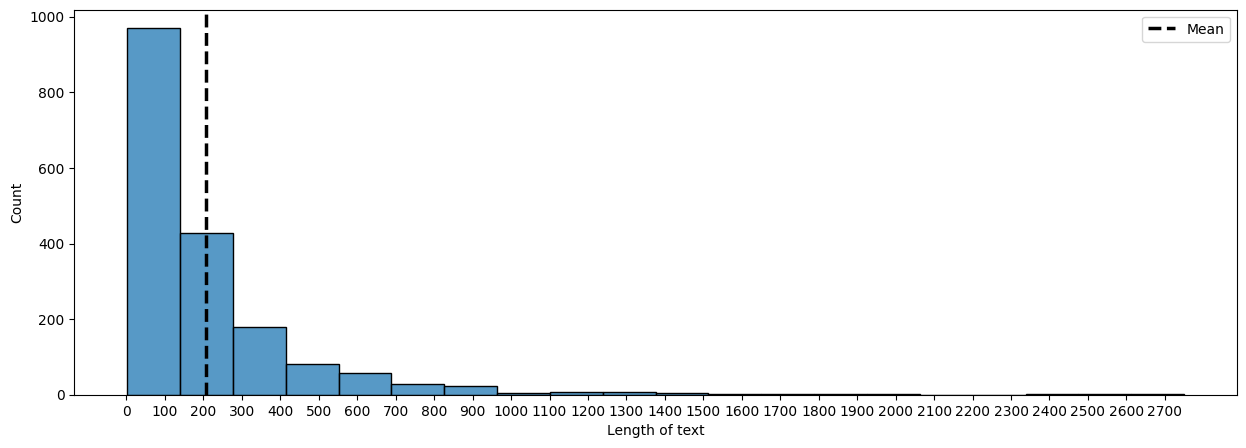

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax = plt.subplots(figsize=(15, 5))

# Plot histogram for the length of Banglish text
train_lengths = train_df["Length"]
sns.histplot(data=train_lengths, bins=20, ax=ax).set(xlabel="Length of text")
ax.axvline(train_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
ax.legend()

# Set x-axis ticks
ax.set_xticks(range(0, max(train_lengths) + 1,100))

plt.show()

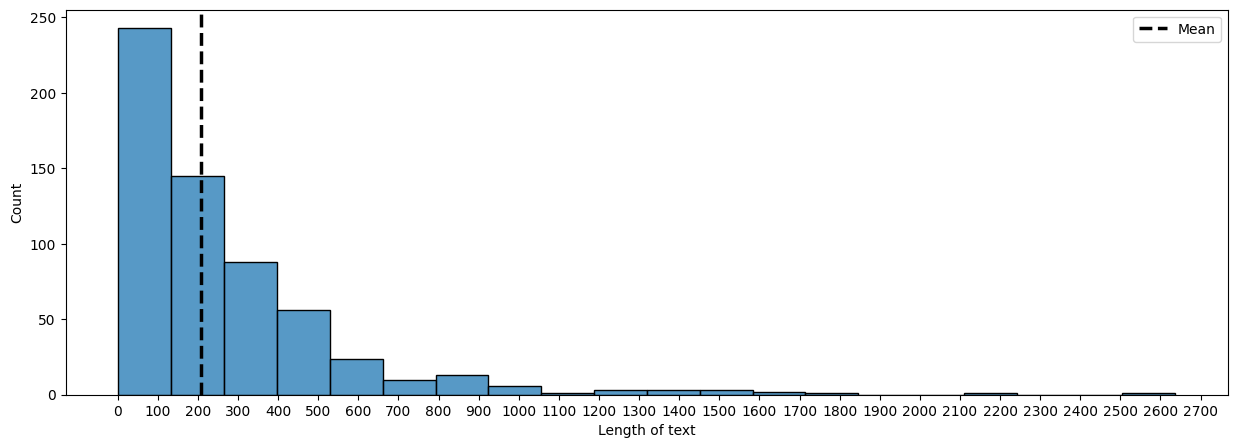

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax = plt.subplots(figsize=(15, 5))

# Plot histogram for the length of Banglish text
val_lengths = val_df["Length"]
sns.histplot(data=val_lengths, bins=20, ax=ax).set(xlabel="Length of text")
ax.axvline(train_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
ax.legend()

# Set x-axis ticks
ax.set_xticks(range(0, max(train_lengths) + 1,100))

plt.show()

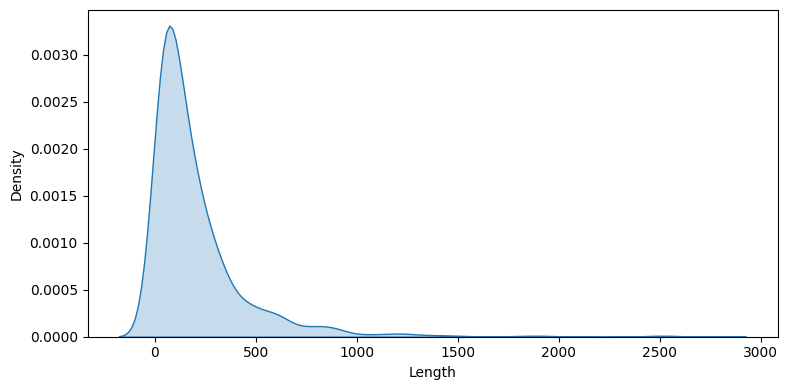

In [13]:
f, axs = plt.subplots(figsize=(8, 4))
sns.kdeplot(train_df, x="Length", fill=True, ax=axs)
f.tight_layout()

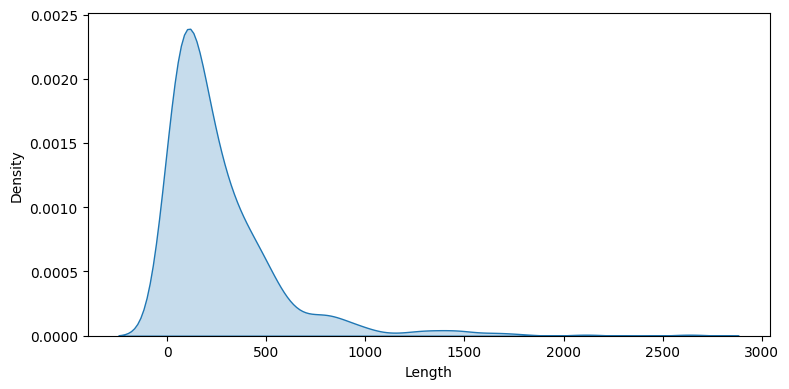

In [14]:
f, axs = plt.subplots(figsize=(8, 4))
sns.kdeplot(val_df, x="Length", fill=True, ax=axs)
f.tight_layout()

In [15]:
import re
def preprocessing(df):
    url_pattern = r'https?://\S+|www\.\S+'
    
    def count_urls(text):
        return len(re.findall(url_pattern, text))

    df['hashtag_count'] = df['text'].apply(lambda x: x.count('#'))
    df['mentions_count'] = df['text'].apply(lambda x: x.count('@'))
    df['url_count'] = df['text'].apply(count_urls)
    return df

df = preprocessing(train_df)

In [16]:
df['url_count'].sum()

1

In [17]:
df['mentions_count'].sum()

2

In [18]:
df['hashtag_count'].sum()

92

In [19]:
import re

def remove_urls(text):
    """Remove URLs from the given text."""
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '', text)

def remove_hashtags(text):
    """Remove hashtags from the given text."""
    if '#' in text:
        text = text.replace('#', '')
    hashtag_pattern = r'#\w+'
    return re.sub(hashtag_pattern, '', text)


def remove_mentions(text):
    """Remove mentions from the given text."""
    # Remove mentions with no space before
    if '@' in text:
        text = text.replace('@', '')
    
    mention_pattern = r'@\S+\b'
    text = re.sub(mention_pattern, '', text)
    # Check if the mention is at the end of the text
    if text.endswith(' @'):
        text = cleaned_text[:-2]  # Remove the space and '@'

    return text

def clean_tweet(text):
    """Clean the given tweet by removing URLs, hashtags, and mentions."""
    cleaned_text = remove_urls(text)
    cleaned_text = remove_hashtags(cleaned_text)
    cleaned_text = remove_mentions(cleaned_text)
    return cleaned_text

In [20]:
train_df['text'] = train_df['text'].apply(clean_tweet)
val_df['text'] = val_df['text'].apply(clean_tweet)

In [21]:
train_df['text'].iloc[55]

"How can I feel like this all the time?. Hey everyone. I'm sorry if this gets kind of long, but I just needed to get it off my chest and maybe ask for some of your thoughts. TL;DR at the bottom if you don't care to read, but I'd be grateful if you would. I've dealt with social anxiety since I was in 1st grade (first time I noticed it affecting me at least). Of course, I didn't know that's what it was at the time, and I just felt really sick all of the time. Tried counseling and such, but I think I was just too young at that point. I'm 19 now and I haven't let this stupid thing beat me down yet. It's hell for sure, but it WILL NOT get the best of me. Anyway, something that I have noticed recently is that I can sometimes get myself into this extremely confident state where I could not care less about what people think of me and I am super outgoing, but it is rare. It doesn't last long, and soon I'm back to trying not to puke in anticipation of the next social encounter I have to face. I 

In [22]:
df = preprocessing(train_df)

In [23]:
df['mentions_count'].sum()

0

In [24]:
df['url_count'].sum()

0

In [25]:
df['hashtag_count'].sum()

0

In [26]:
train_df = train_df.drop(columns = ['Length','hashtag_count','mentions_count','url_count'])

In [27]:
val_df = val_df.drop(columns = ['Length'])

In [28]:
train_df.head()

,id,keyword,text,Classification
0,3u2w5k,run,"21/m. I want to experience young love, but I'v...",0
1,3xbury,outside,Having issues talking to a girl whom I enjoyed...,0
2,3y743u,"run, swim, climb",Need some advice for free social activities. I...,0
3,43bvs7,walk,I spoke to her today.. A few weeks ago I met ...,0
4,442ap2,outside,"How to get over Social Anxiety?. Hello, The ot...",0


In [29]:
with pd.option_context('display.max_colwidth', 0):
    display(train_df.sample(n=5))

,id,keyword,text,Classification
1435,cxm24xw,outside,"I go out to the city alone. Sure it feels a bit awkward, when you're there, not smiling just kind of derping and you see literally everyone being with a group of friends or couples having fun, singing, laughing... And if anyone in their joyous mood would approach you you despise the fake smile you must utter to fit in... I know I cried on my way back home two years ago when I did that the first time. Last time I was just derp. This year...I don't know. I'll go, take pics, and just won't care hopefully. Hey, at least I'm outside eh? Better alone among people than alone in solitude..",2
1259,htiev4,run,"Why do I have no social anxiety AT ALL after a 30 min run?. Hey guys quick question, I’ve recently discovered that if I run before a social event I’m the most confident person ever (especially with a beta blocker). But in the morning before exercise, I get watery eyes in public, feel ‘hollow’ and struggle to keep eye contact without crying. What’s going on?",1
12,4d2itu,"walk, run","I think one of the worst aspects of social anxiety is how it's ""invisible"".. Y'all know what I'm talking about. We walk around with masks on constantly. Always gotta keep up that chipper appearance. There's a Life of Agony song where the lyrics go, ""I need some place to run to. And I need some place to hide. And I need some place where I don't need a smile as my disguise."" That resonates so deeply with me. I just want to get away from everyone sometimes. Cause they don't help. Even if others wanted to help, how'd they know who to help? They can't tell. And we're so damn reclusive that it's nigh impossible to seek help ourselves. And in some special cases, you build up the courage to ask for help and they don't believe you! They say, ""how can you have social anxiety but approach me for help?"" What!? Are you serious? It's taken years to ask and this is your response? And that's what I'm talking about. It invisible. It's not a tangible thing. You don't see it, so you don't believe it. It's something that can just be dismissed. I bet we all wish we could do that. Jut dismiss it. Dismiss all the pain and suffering it causes.",0
388,dfdyp4d,runs,"You sound like a girl version of me lol. I'm 20 in a university also really with no friends, never had a girlfriend either though tried asking someone out once, through texting (i really got my mom to help make a message to send her lol it's pretty sad and i was a college freshman) she said maybe and that it was nice of me to ask, i'm too shy, not good at small talk or starting conversations. It's funny cause my family is outgoing but I'm not. I act normal, like myself only around them. I also hate telling people what i like, I have pretty nerdy interests like computers, video games, despite my anxiety i make youtube videos, though not much people i know watch them and i feel like they would think they're boring. I'm not a fat, ugly, 400 lb guy who doesn't shower, I'm average looking, maybe a little overweight for my height, kind of short cause it runs in my family. I also speak with a monotone voice mostly and don't smile alot lol. It's so annoying when people ask me whats wrong or why i don't smile. I also was born with nystagmus which makes it hard for me to focus on things and occasionally i'll look like i'm dozing off or looking at something else or if i'm tired i will zone out and it looks as if i was high (my mom told me this once) but i don't support 420 so idk what that's like lol. People say join clubs, though I joined a game development club this year and still no friends. Everyone else i see there are making conversation or jumping into conversations but not me. I usually sit alone working on a game i'm making. I only talk when i need to lile at the store, teacher asks a question, speaking on the phone for a purpose, I sell alot on craigslist and communicate and meet so many people that way but just for making business, not really fun stuff. I 

In [30]:
train_df["Classification"].value_counts()

Classification
0    1131
2     395
1     160
3     114
Name: count, dtype: int64

In [31]:
train_df["Classification"].isnull().sum()

0

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    ax = sns.countplot(x=col,  data=train_df, order = train_df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

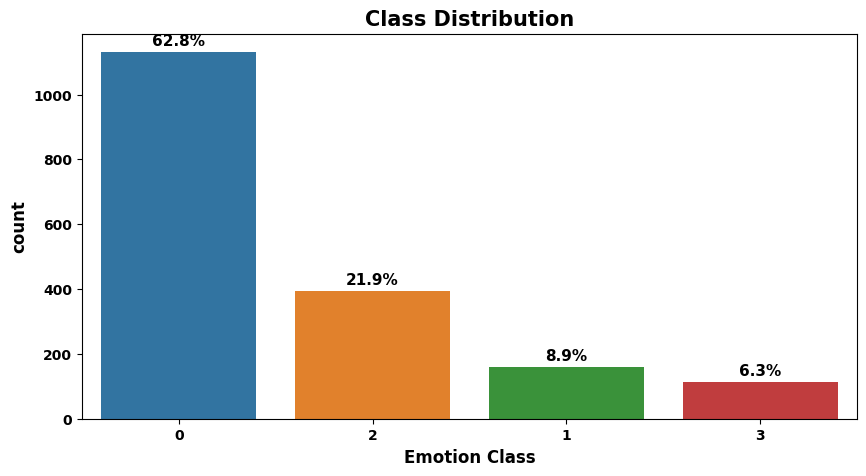

In [33]:
countplot(10,5,'Classification',15,0,'Emotion Class','Class Distribution')

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    ax = sns.countplot(x=col,  data=val_df, order = train_df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

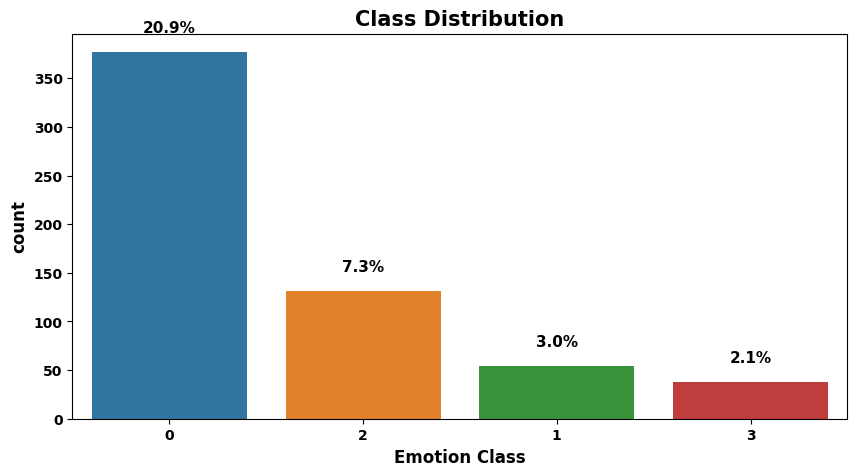

In [35]:
countplot(10,5,'Classification',15,0,'Emotion Class','Class Distribution')

In [36]:
import re
import unicodedata
from bnemo import Translator
from bnunicodenormalizer import Normalizer

translator = Translator()
bnorm = Normalizer(allow_english=True)

# Regex for matching zero witdh joiner variations.
STANDARDIZE_ZW = re.compile(r'(?<=\u09b0)[\u200c\u200d]+(?=\u09cd\u09af)')

# Regex for removing standardized zero width joiner, except in edge cases.
DELETE_ZW = re.compile(r'(?<!\u09b0)[\u200c\u200d](?!\u09cd\u09af)')

# # Regex matching punctuations to remove.
# PUNC = re.compile(r'[`£|¢|Ñ+*/=–•।!()\[\]{};:%\',"“\\’<>./?@#$^&*_~‘—॥”‰�￰￰]+')

# Regex to concate the numbers which are separated by ,
pattern = r'(\d+)[ ,]+(\d+)'


def concate(text):
    return re.sub(pattern, r'\1\2', text)

def removeOptionalZW(text):
    """
    Removes all optional occurrences of ZWNJ or ZWJ from Bangla text.
    """
    text = STANDARDIZE_ZW.sub('\u200D', text)
    text = re.sub(r'\u200d', '', text)
    text = DELETE_ZW.sub('', text)
    return text

# def removePunc(text):
#     """
#     Remove for punctuations from text.
#     """
#     text = PUNC.sub(r" ", text)
#     return text

def normalizeUnicode(text, normalize_nukta=True):
    """
    Normalizes unicode strings using the Normalization Form Canonical
    Composition (NFC) scheme where we first decompose all characters and then
    re-compose combining sequences in a specific order as defined by the
    standard in unicodedata module. Finally, all zero-width joiners are
    removed.
    """
    if normalize_nukta:
        words = [bnorm(word)['normalized'] for word in text.split()]
        text = " ".join([word for word in words if word is not None])
    text = text.replace("\u2047", "-")
    text = text.replace(u"\u098c", u"\u09ef")
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r'#\w+', '', text) # remove hashtag
    text = removeOptionalZW(text)
#     text = removePunc(text)
    return text
def remove_emojis(text):
    """
    Converts emojis to their corresponding English descriptions.
    """
    emoji_pattern = re.compile("["
                               u"\\U0001F600-\\U0001F64F"  # emoticons
                               u"\\U0001F300-\\U0001F5FF"  # symbols & pictographs
                               u"\\U0001F680-\\U0001F6FF"  # transport & map symbols
                               u"\\U0001F1E0-\\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(lambda m: translator.translate(m.group()).text, text)
    return re.sub(emoji_pattern, ' ', text)
   

def lowercase_all_english_letters(text):
#     """
#     Converts all English letters to lowercase.
#     """
    pattern = re.compile(r"\[A-Z\]")
    return pattern.sub(lambda match: match.group().lower(), text)
def preprocessing(text):
    text = remove_emojis(text)
    txt = lowercase_all_english_letters(text)
    txt = concate(txt)
    return normalizeUnicode(text)

In [37]:
train_df['text'] = train_df['text'].apply(lambda x : preprocessing(x))
val_df['text'] = val_df['text'].apply(lambda x : preprocessing(x))

In [38]:
train_df.head()

,id,keyword,text,Classification
0,3u2w5k,run,"21/m. I want to experience young love, but I'v...",0
1,3xbury,outside,Having issues talking to a girl whom I enjoyed...,0
2,3y743u,"run, swim, climb",Need some advice for free social activities. I...,0
3,43bvs7,walk,I spoke to her today.. A few weeks ago I met t...,0
4,442ap2,outside,"How to get over Social Anxiety?. Hello, The ot...",0


In [39]:
class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 32
    MAX_LEN = 100
    SEED = 42
    Roberta_Path = "FacebookAI/roberta-large"
    TOKENIZER_PATH = "FacebookAI/roberta-large"
    num_labels = 4
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
config = Config()

In [40]:
tokenizer = AutoTokenizer.from_pretrained(config.TOKENIZER_PATH)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [41]:
class CustomData(Dataset):
    def __init__(self, df):
        super(CustomData).__init__()

        self.df = df        
        self.target = torch.tensor(df.Classification.values, dtype=torch.long) 
        
        self.encoded = tokenizer(
            df["text"].tolist(),
            df['keyword'].tolist(),
            padding = True,            
            max_length = config.MAX_LEN,
            truncation = True,
            add_special_tokens=True, 
        )   
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        target = self.target[index]
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "target": target
        }

In [42]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel,self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.Roberta_Path)
        self.model_config.update({"output_hidden_states":True,
                       "hidden_dropout_prob": 0.0,
                       "layer_norm_eps": 1e-7})

        self.bert = RobertaModel.from_pretrained(config.Roberta_Path, config= self.model_config)
        self.attention = nn.Sequential(            
            nn.Linear(1024, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        
#         self.dropout1 = nn.Dropout(0.3)
        self.out = nn.Linear(1024, config.num_labels)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
        elif isinstance(module, nn.Sequential):
            # Initialize the weights of each sub-module in the Sequential
            for submodule in module:
                if hasattr(submodule, 'weight'):  # Check if the sub-module has a 'weight' attribute
                    self._init_weights(submodule)
        
    def forward(self, input_ids, attention_mask):
        
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_layer_hidden_states = output.hidden_states[-1]

        # The number of cells is MAX_LEN.
        # The size of the hidden state of each cell is 768 (for roberta-base).
        # In order to condense hidden states of all cells to a context vector,
        # we compute a weighted average of the hidden states of all cells.
        # We compute the weight of each cell, using the attention neural network.
        weights = self.attention(last_layer_hidden_states)
         # weights.shape is BATCH_SIZE x MAX_LEN x 1
        # last_layer_hidden_states.shape is BATCH_SIZE x MAX_LEN x 768        
        # Now we compute context_vector as the weighted average.
        # context_vector.shape is BATCH_SIZE x 768
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)   
        return self.out(context_vector)


In [43]:
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:197]    
    attention_parameters = named_parameters[199:203]
    regressor_parameters = named_parameters[203:]
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})

    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = 2e-5

        if layer_num >= 69:        
            lr = 5e-5

        if layer_num >= 133:
            lr = 1e-4

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters)

In [44]:
from transformers import AutoTokenizer, DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [45]:
# engine.py
import evaluate
from tqdm.auto import tqdm
from sklearn.metrics import f1_score


class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        DEVICE = config.DEVICE
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(DEVICE)
            attention_mask = data["attention_mask"].to(DEVICE)            
            target = data["target"].to(DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        DEVICE = config.DEVICE
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(DEVICE)
                attention_mask = data["attention_mask"].to(DEVICE)            
                target = data["target"].to(DEVICE)
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [46]:
from transformers import get_scheduler

def run_training(save_model = False):
    train_dataset = CustomData(train_df)    
    val_dataset = CustomData(val_df)
    
    train_loader = DataLoader(train_dataset, batch_size = Config().BATCH_SIZE,
                              collate_fn=data_collator, shuffle =True, num_workers=2)    
    val_loader = DataLoader(val_dataset, batch_size = Config().BATCH_SIZE,
                            drop_last=False,collate_fn=data_collator, shuffle=False, num_workers=2)   
    set_random_seed(config.SEED)
    model = CustomModel()
    model.to(config.DEVICE)
    
#     optimizer = create_optimizer(model) 
    optimizer = torch.optim.AdamW(model.parameters(), lr= 3e-5, weight_decay=0.01)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    
    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f" Epoch: {epoch + 1} | Training_loss: {round(train_loss,5)} | Validation_loss: {round(val_loss,5)} | Val_Score: {round(val_score,5)}")
        
        if val_score > best_score:
            best_score = val_score
            
            if save_model:
                torch.save(model.state_dict(),f"model.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return best_score

In [47]:
score =run_training(save_model = True)
print(f"overall Score: {score}")

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

 Epoch: 1 | Training_loss: 1.05199 | Validation_loss: 0.90037 | Val_Score: 0.58109


  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

 Epoch: 2 | Training_loss: 0.77443 | Validation_loss: 0.81457 | Val_Score: 0.3893


  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

 Epoch: 3 | Training_loss: 0.52684 | Validation_loss: 0.80793 | Val_Score: 0.31045


  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

 Epoch: 4 | Training_loss: 0.31663 | Validation_loss: 1.11383 | Val_Score: 0.30466


  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

 Epoch: 5 | Training_loss: 0.12637 | Validation_loss: 1.26425 | Val_Score: 0.29799


  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

 Epoch: 6 | Training_loss: 0.04844 | Validation_loss: 1.34768 | Val_Score: 0.26888


  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

 Epoch: 7 | Training_loss: 0.00889 | Validation_loss: 1.63496 | Val_Score: 0.30674
overall Score: 0.5810945979082663
